In [1]:
import mlrun

In [2]:
#import sys
#!{sys.executable} -m pip install --upgrade xgboost     --quiet # upgrade boto to the latest vesion

In [3]:
project = mlrun.get_or_create_project(
    name="sagemaker-v3", 
    user_project=True,
    parameters={
        # "source" : "git://github.com/mlrun/demo-sagemaker#main",
        "default_image" : "yonishelach/sagemaker-demo"
    }
)

> 2024-02-08 10:46:56,324 [info] Project loaded successfully: {'project_name': 'sagemaker-v3'}


In [4]:
model_path = 's3://sagemaker-us-east-2-934638699319/payment-classification/output/sagemaker-xgboost-2024-02-07-17-07-42-480/output/model.tar.gz'

In [5]:
test_serving_function = project.set_function(
        func="src/functions/serving.py",
        name="test-serving",
        kind="serving",
)

In [6]:
import pandas as pd
data = pd.read_csv(
    "test.csv")

In [7]:
data_cols = list(data.columns)

In [8]:
data_cols

['transaction_category_key',
 'amount_avg_1d',
 'receiver_id',
 'sender_id',
 'amount',
 'timestamp_year',
 'timestamp_month',
 'timestamp_day',
 'timestamp_hour',
 'timestamp_minute',
 'timestamp_second',
 'distance']

In [9]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore

# create feature vector on top of aggreagations
# Define the list of features we will be using
features = [f"transactions-v13.{name}" for name in data_cols] 

# Define the feature vector name for future reference
fv_name = 'transactions-vector-v3'

# Define the feature vector using our Feature Store (fstore)
transactions_fv = fstore.FeatureVector(fv_name, 
                          features,                           
                          description='stocks information')

#label_feature = 'transactions-v2.transaction_category',
# Save the feature vector in the Feature Store
transactions_fv.save()

In [10]:
import mlrun.feature_store as fs
# resp = fs.FeatureVector.get_offline_features("store://feature-vectors/sagemaker-v3-admin/transactions-vector-v3:latest")
# #Preview the dataset
# resp.to_dataframe().tail(5)

svc = fs.FeatureVector.get_online_feature_service("store://feature-vectors/sagemaker-v3-admin/transactions-vector-v3:latest")
resp = svc.get([{"transaction_id": "42"}])

In [11]:
resp

[None]

In [12]:
# # Set the topology and get the graph object:
# graph = test_serving_function.set_topology("flow", engine="async")

# # Add the steps:
# graph.to("XGBModelServer",
#          name="xgboost-model",
#          model_path=model_path) \
#      .to(handler="postprocess", name="postprocess").respond()

# # Plot to graph:
# test_serving_function.plot(rankdir='LR')

In [19]:
#print(test_serving_function.spec.to_yaml())

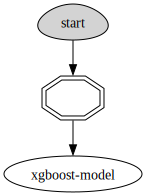

In [29]:

# test_serving_function.set_topology(
#     "router",
#     mlrun.serving.routers.EnrichmentModelRouter(
#         feature_vector_uri="store://feature-vectors/sagemaker-v3-admin/transactions-vector-v3:latest",
#         impute_policy={"*": "$mean"}),
# )
# # add the 3 trained models to the Ensemble
# for model in project.list_models('', tag='latest'):
#     name = model.spec.db_key
#     serving_fn.add_model(name, class_name="ClassifierModel", model_path=model.uri)

test_serving_function.add_model("xgboost-model", class_name="XGBModelServer", model_path=model_path)

# Plot the ensemble configuration
test_serving_function.spec.graph.plot()

In [30]:
server = test_serving_function.to_mock_server()

> 2024-02-08 11:07:24,154 [info] model xgboost-model was loaded
> 2024-02-08 11:07:24,155 [info] Loaded ['xgboost-model']


In [39]:
import pandas as pd
data = pd.read_csv(
    "test.csv")

In [40]:
data = data.drop('transaction_category_key', axis=1)

In [41]:
data = data[:1]

In [42]:
data

,amount_avg_1d,receiver_id,sender_id,amount,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,timestamp_minute,timestamp_second,distance
0,53.07,4.726537e+15,4.070479e+15,53.07,2021,2,19,19,37,40,26.535


In [45]:
data_ls = data.values.tolist()
data_ls

[[53.07,
  4726536548206059.0,
  4070478627221885.0,
  53.07,
  2021.0,
  2.0,
  19.0,
  19.0,
  37.0,
  40.0,
  26.535]]

In [47]:
inputs_data = {'inputs': data_ls }

In [48]:
response = server.test(body=inputs_data)

> 2024-02-08 11:14:12,578 [error] run error, Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/server.py", line 280, in run
    response = self.graph.run(event, **(extra_args or {}))
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/states.py", line 548, in run
    raise exc
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/states.py", line 531, in run
    return self._handler(event, *args, **kwargs)
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/routers.py", line 148, in do_event
    event = self.preprocess(event)
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/serving/routers.py", line 1174, in preprocess
    event.body["inputs"] = self._feature_service.get(
  File "/home/sagemaker-user/.conda/envs/smdemo/lib/python3.9/site-packages/mlrun/feature_store/fea

RuntimeError: failed (400): MLRunInvalidArgumentError: input list must be in the same size of the index_keys list

In [38]:
print(response)

NameError: name 'response' is not defined